In [14]:
import VariationalAutoencoder
import numpy as np
import scipy as sp
import time, os
import gzip, pickle, copy, pickle
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from mmd import MMD_3_Sample_Test
from tqdm.notebook import tnrange
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

print("Loading MNIST data")
# Retrieved from: http://deeplearning.net/data/mnist/mnist.pkl.gz

f = gzip.open('mnist.pkl.gz', 'rb')
(x_train, t_train), (x_valid, t_valid), (x_test, t_test) = pickle.load(f, encoding="latin1")
f.close()
x_train = (x_train > 0).astype('float')
x_valid = (x_valid > 0).astype('float')
x_test = (x_test > 0).astype('float')

data = x_train
samp_size = 1000

verbose = True

runs = 25
dimZ = 20
HU_decoder = 400
HU_encoder = HU_decoder

dimZ2 = dimZ
HU_decoder2 = HU_decoder
HU_encoder2 = HU_decoder2

batch_size = 100
L = 1
learning_rate = 0.01

sig = 0.05


Loading MNIST data


In [3]:
data = x_train.copy()

In [4]:
rand_indexes = np.random.permutation(np.arange(x_train.shape[0], dtype=np.int))

In [5]:
data = x_train.copy()[rand_indexes,:]

In [6]:
# experiment_df_M1 = pd.DataFrame(columns=['ratio', 'pvalue', 'tstat', 'sigma', 
#                                       'MMDXY', 'MMDXZ', 'vae1_score', 'vae2_score', 'unenc_score'])

# experiment_df_M2 = experiment_df_M1.copy()

In [7]:
ratios = [0.3, 0.5, 1, 2, 3.3, 5]

In [8]:
for exp_index in range(13):
    print('EXPERIMENT No', exp_index, '\n\n\n\n')
    for ratio in ratios:
        # ratios=np.array([0.5,1,2])
        rand_indexes = np.random.permutation(np.arange(x_train.shape[0], dtype=np.int))
        data = x_train.copy()[rand_indexes,:]
        t_size2 = 2000
        t_size1 = int(t_size2 / ratio)

        set1, set2 = train_test_split(list(range(data.shape[0])), train_size=t_size1 + t_size2)
        data1 = data[set1[0:t_size1], :]
        data2 = data[set1[t_size1:t_size2 + t_size1], :]
        set2 = set2[0:samp_size]
        data_holdout = data[set2, :]

        [N1, dimX] = data1.shape
        [N2, dimX] = data2.shape
        encoder1 = VariationalAutoencoder.VA(HU_decoder, HU_encoder, dimX, 
                                             dimZ, batch_size, L, learning_rate, 
                                             continous=False)
        encoder2 = VariationalAutoencoder.VA(HU_decoder2, HU_encoder2, dimX, 
                                             dimZ2, batch_size, L, learning_rate,
                                             continous=False)

        print("Creating Theano functions")
        encoder1.createGradientFunctions()
        encoder2.createGradientFunctions()
        print("Initializing weights and biases")
        encoder1.initParams()
        encoder2.initParams()

        begin = time.time()
        maxiter = 2000
        testlowerbound1 = testlowerbound2 = -np.Inf
        for j in tnrange(maxiter):
            encoder1.iterate(data1)
            if j % 1 == 0:
                oldlower = testlowerbound1
                train_lower1 = encoder1.getLowerBound(data1)
                testlowerbound1 = encoder1.getLowerBound(data_holdout)
    #             if (verbose):
    #                 print(("Encoder 1 Iteration %d| lower bound train = %.2f |lower bound test 1= %.2f"
    #                        % (j, train_lower1 / float(N1), testlowerbound1 / samp_size)))
                if (oldlower >= testlowerbound1):
                    break
                best_encoder1 = copy.deepcopy(encoder1)

        encoder1 = best_encoder1

        for j in tnrange(maxiter):
            encoder2.iterate(data2)

            if j % 1 == 0:
                oldlower = testlowerbound2
                train_lower2 = encoder2.getLowerBound(data2)
                testlowerbound2 = encoder2.getLowerBound(data_holdout)
    #             if (verbose):
    #                 print(("Encoder 2 Iteration %d| lower bound train = %.2f |lower bound test 1= %.2f"
    #                        % (j, train_lower2 / float(N2), testlowerbound2 / samp_size)))
                if (oldlower > testlowerbound2):
                    break
                best_encoder2 = copy.deepcopy(encoder2)

        encoder2 = best_encoder2
        end = time.time()

        samples1 = encoder1.sample(N=samp_size)
        samples2 = encoder2.sample(N=samp_size)

        pvalue_1, tstat_1, sigma_1, MMDXY_1, MMDXZ_1 = MMD_3_Sample_Test(data_holdout, 
                                                               samples1, 
                                                               samples2, 
                                                               computeMMDs=True)
        pvalue_2, tstat_2, sigma_2, MMDXY_2, MMDXZ_2 = MMD_3_Sample_Test(data_holdout, 
                                                           samples2, 
                                                           samples1, 
                                                           computeMMDs=True)
        print(("MMD(enc1 samples,real): %.4f MMD(enc2 samples,real): %.4f , pvalue: %.2f" % (MMDXY_1, MMDXZ_1, pvalue_1)))
        # Regressions
        ##Train regression

        data1_enc = encoder1.encode(x_valid)
        data2_enc = encoder2.encode(x_valid)
        test1_enc = encoder1.encode(x_test)
        test2_enc = encoder2.encode(x_test)

        LogReg_VAE = linear_model.LogisticRegression()
        LogReg_VAE.fit(data1_enc, t_valid)
        vae1_score = LogReg_VAE.score(test1_enc, t_test)
        LogReg_VAE = linear_model.LogisticRegression()
        LogReg_VAE.fit(data2_enc, t_valid)
        vae2_score = LogReg_VAE.score(test2_enc, t_test)
        
        LogReg_VAE = linear_model.LogisticRegression()
        LogReg_VAE.fit(x_train, t_train)
        unenc_score = LogReg_VAE.score(x_valid, t_valid)

        
        print(("Accuracy 1:%.2f Accuracy2:%.2f" % (vae1_score, vae2_score)))
        buf_dict = {'ratio': ratio, 'pvalue': pvalue_1, 'tstat': tstat_1, 
                 'sigma': sigma_1, 'MMDXY': MMDXY_1, 'MMDXZ': MMDXZ_1, 
                 'vae1_score': vae1_score, 'vae2_score': vae2_score, 
                    'unenc_score': unenc_score}
        experiment_df_M1 = experiment_df_M1.append(buf_dict, ignore_index=True)

        buf_dict = {'ratio': ratio, 'pvalue': pvalue_2, 'tstat': tstat_2, 
             'sigma': sigma_2, 'MMDXY': MMDXY_2, 'MMDXZ': MMDXZ_2, 
             'vae1_score': vae1_score, 'vae2_score': vae2_score,
                   'unenc_score': unenc_score}
        experiment_df_M2 = experiment_df_M2.append(buf_dict, ignore_index=True)

EXPERIMENT No 0 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.882006748732527e-05
Diff_Var: () 6.882006748732548e-05
MMD(enc1 samples,real): 0.0800 MMD(enc2 samples,real): 0.1850 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.92 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.510551615423881e-05
Diff_Var: () 8.510551615423858e-05
MMD(enc1 samples,real): 0.1554 MMD(enc2 samples,real): 0.1633 , pvalue: 0.80


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.754024318349828e-05
Diff_Var: () 5.754024318349873e-05
MMD(enc1 samples,real): 0.2280 MMD(enc2 samples,real): 0.1967 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.219086471318859e-05
Diff_Var: () 5.2190864713188376e-05
MMD(enc1 samples,real): 0.2179 MMD(enc2 samples,real): 0.1756 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.84
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.473990449159046e-05
Diff_Var: () 6.473990449158936e-05
MMD(enc1 samples,real): 0.2265 MMD(enc2 samples,real): 0.2067 , pvalue: 0.01


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.978343720672506e-05
Diff_Var: () 5.978343720672506e-05
MMD(enc1 samples,real): 0.2180 MMD(enc2 samples,real): 0.1456 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.89
EXPERIMENT No 1 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.578323449992218e-05
Diff_Var: () 7.578323449992218e-05
MMD(enc1 samples,real): 0.1395 MMD(enc2 samples,real): 0.2019 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.89 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.75789160552449e-05
Diff_Var: () 6.75789160552449e-05
MMD(enc1 samples,real): 0.2123 MMD(enc2 samples,real): 0.1891 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.870320317552554e-05
Diff_Var: () 7.870320317552554e-05
MMD(enc1 samples,real): 0.1724 MMD(enc2 samples,real): 0.1705 , pvalue: 0.41


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.962056927931191e-05
Diff_Var: () 7.962056927931125e-05
MMD(enc1 samples,real): 0.2118 MMD(enc2 samples,real): 0.1786 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.227555819065912e-05
Diff_Var: () 7.227555819065979e-05
MMD(enc1 samples,real): 0.2310 MMD(enc2 samples,real): 0.1640 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.83 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.263826988339537e-05
Diff_Var: () 7.263826988339581e-05
MMD(enc1 samples,real): 0.2002 MMD(enc2 samples,real): 0.1612 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.89
EXPERIMENT No 2 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.419626025416641e-05
Diff_Var: () 7.419626025416619e-05
MMD(enc1 samples,real): 0.1120 MMD(enc2 samples,real): 0.2019 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.92 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 9.377000942280111e-05
Diff_Var: () 9.377000942280111e-05
MMD(enc1 samples,real): 0.2029 MMD(enc2 samples,real): 0.1698 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 9.590140396733817e-05
Diff_Var: () 9.590140396733772e-05
MMD(enc1 samples,real): 0.1804 MMD(enc2 samples,real): 0.1561 , pvalue: 0.01


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.077239182392703e-05
Diff_Var: () 7.077239182392613e-05
MMD(enc1 samples,real): 0.2335 MMD(enc2 samples,real): 0.1371 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.90
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.927074328398047e-05
Diff_Var: () 5.9270743283980256e-05
MMD(enc1 samples,real): 0.2362 MMD(enc2 samples,real): 0.1845 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.544153602861047e-05
Diff_Var: () 5.5441536028611356e-05
MMD(enc1 samples,real): 0.2636 MMD(enc2 samples,real): 0.1658 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.89
EXPERIMENT No 3 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.909573985451114e-05
Diff_Var: () 4.9095739854510925e-05
MMD(enc1 samples,real): 0.0376 MMD(enc2 samples,real): 0.1994 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.93 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.439647193657733e-05
Diff_Var: () 7.439647193657777e-05
MMD(enc1 samples,real): 0.1953 MMD(enc2 samples,real): 0.1869 , pvalue: 0.16


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.553412118853523e-05
Diff_Var: () 7.553412118853523e-05
MMD(enc1 samples,real): 0.1474 MMD(enc2 samples,real): 0.1334 , pvalue: 0.05


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.90
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.695605449155546e-05
Diff_Var: () 6.695605449155591e-05
MMD(enc1 samples,real): 0.2045 MMD(enc2 samples,real): 0.1731 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.7296776934383306e-05
Diff_Var: () 5.729677693438264e-05
MMD(enc1 samples,real): 0.2230 MMD(enc2 samples,real): 0.2031 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.833497015503604e-05
Diff_Var: () 5.833497015503604e-05
MMD(enc1 samples,real): 0.2432 MMD(enc2 samples,real): 0.2044 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
EXPERIMENT No 4 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 9.353808392497284e-05
Diff_Var: () 9.353808392497272e-05
MMD(enc1 samples,real): 0.1397 MMD(enc2 samples,real): 0.1716 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.90 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.152952124504291e-05
Diff_Var: () 5.152952124504291e-05
MMD(enc1 samples,real): 0.0571 MMD(enc2 samples,real): 0.2071 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.91 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.346403855499805e-05
Diff_Var: () 7.346403855499782e-05
MMD(enc1 samples,real): 0.2102 MMD(enc2 samples,real): 0.1733 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.81 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.172637816365016e-05
Diff_Var: () 6.17263781636495e-05
MMD(enc1 samples,real): 0.2190 MMD(enc2 samples,real): 0.1725 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.0243528222660476e-05
Diff_Var: () 6.0243528222660476e-05
MMD(enc1 samples,real): 0.2074 MMD(enc2 samples,real): 0.1896 , pvalue: 0.01


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.291774021907597e-05
Diff_Var: () 6.291774021907552e-05
MMD(enc1 samples,real): 0.2355 MMD(enc2 samples,real): 0.1735 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.87
EXPERIMENT No 5 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.771183136119328e-05
Diff_Var: () 8.771183136119328e-05
MMD(enc1 samples,real): 0.1197 MMD(enc2 samples,real): 0.1351 , pvalue: 0.95


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.92 Accuracy2:0.90
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.376476205778352e-05
Diff_Var: () 7.376476205778328e-05
MMD(enc1 samples,real): 0.1334 MMD(enc2 samples,real): 0.1576 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.89 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.947310026516699e-05
Diff_Var: () 5.947310026516632e-05
MMD(enc1 samples,real): 0.2238 MMD(enc2 samples,real): 0.1647 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.407665753037938e-05
Diff_Var: () 6.407665753037959e-05
MMD(enc1 samples,real): 0.2122 MMD(enc2 samples,real): 0.2188 , pvalue: 0.80


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.854627992831428e-05
Diff_Var: () 7.854627992831518e-05
MMD(enc1 samples,real): 0.2071 MMD(enc2 samples,real): 0.1322 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.90
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.4627468804998074e-05
Diff_Var: () 5.4627468804998074e-05
MMD(enc1 samples,real): 0.2407 MMD(enc2 samples,real): 0.1955 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.86
EXPERIMENT No 6 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.825660009467798e-05
Diff_Var: () 4.8256600094678315e-05
MMD(enc1 samples,real): 0.0448 MMD(enc2 samples,real): 0.1938 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.93 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.666647129509539e-05
Diff_Var: () 7.666647129509539e-05
MMD(enc1 samples,real): 0.1052 MMD(enc2 samples,real): 0.1705 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.91 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.259575365923638e-05
Diff_Var: () 8.259575365923771e-05
MMD(enc1 samples,real): 0.1850 MMD(enc2 samples,real): 0.1828 , pvalue: 0.40


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.268433961015204e-05
Diff_Var: () 6.26843396101516e-05
MMD(enc1 samples,real): 0.2027 MMD(enc2 samples,real): 0.1667 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.247804340237714e-05
Diff_Var: () 6.24780434023767e-05
MMD(enc1 samples,real): 0.2350 MMD(enc2 samples,real): 0.1936 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.83 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.038862430784965e-05
Diff_Var: () 6.0388624307849875e-05
MMD(enc1 samples,real): 0.2528 MMD(enc2 samples,real): 0.1777 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.88
EXPERIMENT No 7 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.215600165437788e-05
Diff_Var: () 7.21560016543781e-05
MMD(enc1 samples,real): 0.1144 MMD(enc2 samples,real): 0.1675 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.91 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.300252702931921e-05
Diff_Var: () 8.300252702931921e-05
MMD(enc1 samples,real): 0.1609 MMD(enc2 samples,real): 0.1644 , pvalue: 0.65


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.89 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.594576096577464e-05
Diff_Var: () 6.594576096577441e-05
MMD(enc1 samples,real): 0.1835 MMD(enc2 samples,real): 0.1877 , pvalue: 0.70


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.783228573076199e-05
Diff_Var: () 7.783228573076199e-05
MMD(enc1 samples,real): 0.1971 MMD(enc2 samples,real): 0.1793 , pvalue: 0.02


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.21842853406221e-05
Diff_Var: () 8.21842853406221e-05
MMD(enc1 samples,real): 0.1920 MMD(enc2 samples,real): 0.1776 , pvalue: 0.06


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.976968614629541e-05
Diff_Var: () 4.9769686146295635e-05
MMD(enc1 samples,real): 0.2309 MMD(enc2 samples,real): 0.2005 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.86
EXPERIMENT No 8 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.098157294573603e-05
Diff_Var: () 6.098157294573614e-05
MMD(enc1 samples,real): 0.0594 MMD(enc2 samples,real): 0.1751 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.93 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.377349670298812e-05
Diff_Var: () 6.377349670298857e-05
MMD(enc1 samples,real): 0.1310 MMD(enc2 samples,real): 0.1973 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.90 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.603752736971485e-05
Diff_Var: () 8.603752736971507e-05
MMD(enc1 samples,real): 0.2049 MMD(enc2 samples,real): 0.1681 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.420441747248675e-05
Diff_Var: () 6.420441747248609e-05
MMD(enc1 samples,real): 0.1893 MMD(enc2 samples,real): 0.1540 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.192131865762052e-05
Diff_Var: () 6.192131865761964e-05
MMD(enc1 samples,real): 0.2251 MMD(enc2 samples,real): 0.1766 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.83 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.6613174092330844e-05
Diff_Var: () 5.661317409233063e-05
MMD(enc1 samples,real): 0.2267 MMD(enc2 samples,real): 0.1573 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.88
EXPERIMENT No 9 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.46767594979571e-05
Diff_Var: () 4.4676759497957314e-05
MMD(enc1 samples,real): 0.0448 MMD(enc2 samples,real): 0.1837 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.92 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.635429090233517e-05
Diff_Var: () 7.635429090233517e-05
MMD(enc1 samples,real): 0.1538 MMD(enc2 samples,real): 0.1780 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.89 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.844783138179192e-05
Diff_Var: () 7.844783138179258e-05
MMD(enc1 samples,real): 0.2066 MMD(enc2 samples,real): 0.1630 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.032959323789724e-05
Diff_Var: () 6.0329593237897016e-05
MMD(enc1 samples,real): 0.2053 MMD(enc2 samples,real): 0.2203 , pvalue: 0.97


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.61916219849074e-05
Diff_Var: () 7.619162198490763e-05
MMD(enc1 samples,real): 0.1980 MMD(enc2 samples,real): 0.1856 , pvalue: 0.08


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.926952567554144e-05
Diff_Var: () 6.926952567554188e-05
MMD(enc1 samples,real): 0.2211 MMD(enc2 samples,real): 0.1888 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.82 Accuracy2:0.88
EXPERIMENT No 10 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.73355800965781e-05
Diff_Var: () 7.733558009657767e-05
MMD(enc1 samples,real): 0.1374 MMD(enc2 samples,real): 0.2105 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.90 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.030148051442269e-05
Diff_Var: () 7.030148051442269e-05
MMD(enc1 samples,real): 0.2165 MMD(enc2 samples,real): 0.1435 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.90
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.50780183636306e-05
Diff_Var: () 7.50780183636306e-05
MMD(enc1 samples,real): 0.1889 MMD(enc2 samples,real): 0.1979 , pvalue: 0.85


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.543570176498758e-05
Diff_Var: () 6.543570176498824e-05
MMD(enc1 samples,real): 0.2204 MMD(enc2 samples,real): 0.1779 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.617341395621482e-05
Diff_Var: () 6.617341395621438e-05
MMD(enc1 samples,real): 0.2317 MMD(enc2 samples,real): 0.1904 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.347884505157348e-05
Diff_Var: () 4.347884505157348e-05
MMD(enc1 samples,real): 0.2393 MMD(enc2 samples,real): 0.2165 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.85
EXPERIMENT No 11 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.055582590684321e-05
Diff_Var: () 6.0555825906843654e-05
MMD(enc1 samples,real): 0.0785 MMD(enc2 samples,real): 0.1942 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.92 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.38007247899404e-05
Diff_Var: () 8.380072478993952e-05
MMD(enc1 samples,real): 0.1089 MMD(enc2 samples,real): 0.1554 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.90 Accuracy2:0.90
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.53963380484725e-05
Diff_Var: () 8.539633804847205e-05
MMD(enc1 samples,real): 0.1715 MMD(enc2 samples,real): 0.1792 , pvalue: 0.80


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.196542998953892e-05
Diff_Var: () 7.196542998953892e-05
MMD(enc1 samples,real): 0.2235 MMD(enc2 samples,real): 0.1721 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.82 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.238690639416736e-05
Diff_Var: () 7.238690639416759e-05
MMD(enc1 samples,real): 0.2048 MMD(enc2 samples,real): 0.1783 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.320851544387925e-05
Diff_Var: () 6.320851544387903e-05
MMD(enc1 samples,real): 0.2134 MMD(enc2 samples,real): 0.1714 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.87
EXPERIMENT No 12 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.4288533718261325e-05
Diff_Var: () 4.428853371826177e-05
MMD(enc1 samples,real): 0.0499 MMD(enc2 samples,real): 0.2343 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.93 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.113779403195495e-05
Diff_Var: () 8.113779403195518e-05
MMD(enc1 samples,real): 0.1781 MMD(enc2 samples,real): 0.1461 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.815076095028441e-05
Diff_Var: () 8.815076095028464e-05
MMD(enc1 samples,real): 0.1448 MMD(enc2 samples,real): 0.1468 , pvalue: 0.58


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.89 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.716321836621123e-05
Diff_Var: () 6.716321836621145e-05
MMD(enc1 samples,real): 0.2122 MMD(enc2 samples,real): 0.1302 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.158731576511755e-05
Diff_Var: () 5.158731576511777e-05
MMD(enc1 samples,real): 0.2213 MMD(enc2 samples,real): 0.1980 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 3.5320990370894506e-05
Diff_Var: () 3.5320990370894066e-05
MMD(enc1 samples,real): 0.2467 MMD(enc2 samples,real): 0.2315 , pvalue: 0.01


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.83


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# experiment_df_M2.to_csv('experiment_df_M2.csv')
# experiment_df_M1.to_csv('experiment_df_M1.csv')

In [21]:
plot_graph[0]

array([13.,  9.,  7.,  2.,  2.,  0.])

In [24]:
- plot_graph[0] - plot_graph[1]

array([-13., -16., -20., -14., -15., -13.])

In [26]:
np.invert(True)

False

In [34]:
plt.rcParams.update({'font.size': 18})

Text(0.5, 1.0, 'Relative MMD Decisions')

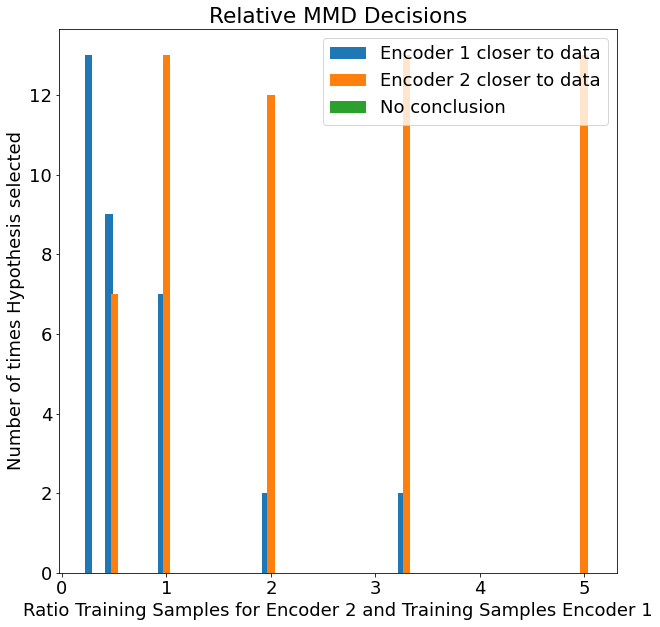

In [35]:
buf_for_plot_1 = experiment_df_M1.copy()
buf_for_plot_2 = experiment_df_M1.copy()
ratios_for_plot = np.array(ratios)

plot_graph = []
for buf_for_plot in [experiment_df_M1.copy(), experiment_df_M2.copy()]:
    buf_for_plot['accept_H0'] = buf_for_plot['pvalue']>0.05
    buf_bin_val = np.zeros_like(ratios)
    for ratio_index, ratio in enumerate(ratios):
        buf_bin_val[ratio_index] += buf_for_plot[buf_for_plot['ratio']==ratio]['accept_H0'].sum()
    plot_graph.append(buf_bin_val.copy())

buf_for_plot_1 = experiment_df_M1.copy()
buf_for_plot_2 = experiment_df_M2.copy()
buf_for_plot_1['accept_H0'] = buf_for_plot_1['pvalue']>0.05
buf_for_plot_2['accept_H0'] = buf_for_plot_2['pvalue']>0.05
buf_bin_val = np.zeros_like(ratios)
for ratio_index, ratio in enumerate(ratios):
    buf_bin_val[ratio_index] += np.invert(np.logical_or(buf_for_plot_1[buf_for_plot['ratio']==ratio]['accept_H0'], 
                                              buf_for_plot_2[buf_for_plot['ratio']==ratio]['accept_H0'])).sum()
plot_graph.append(buf_bin_val.copy())

# plot_graph.append(np.ones_like(buf_bin_val)*13 - plot_graph[0] - plot_graph[1])

plt.figure(figsize=(10,10))
plt.bar(ratios_for_plot - 0.05, plot_graph[0], width=0.07, label='Encoder 1 closer to data')
plt.bar(ratios_for_plot, plot_graph[1], width=0.07, label='Encoder 2 closer to data')
plt.bar(ratios_for_plot + 0.05, plot_graph[2], width=0.05, label='No conclusion')
plt.xlabel('Ratio Training Samples for Encoder 2 and Training Samples Encoder 1')
plt.ylabel('Number of times Hypothesis selected')
plt.legend()
plt.title('Relative MMD Decisions')

In [45]:
buf_for_plot['unenc_score']

0     0.9203
1     0.9203
2     0.9203
3     0.9203
4     0.9203
       ...  
73    0.9203
74    0.9203
75    0.9203
76    0.9203
77    0.9203
Name: unenc_score, Length: 78, dtype: float64

Text(0.5, 1.0, 'Average Accuracy Using Autoencoder Features')

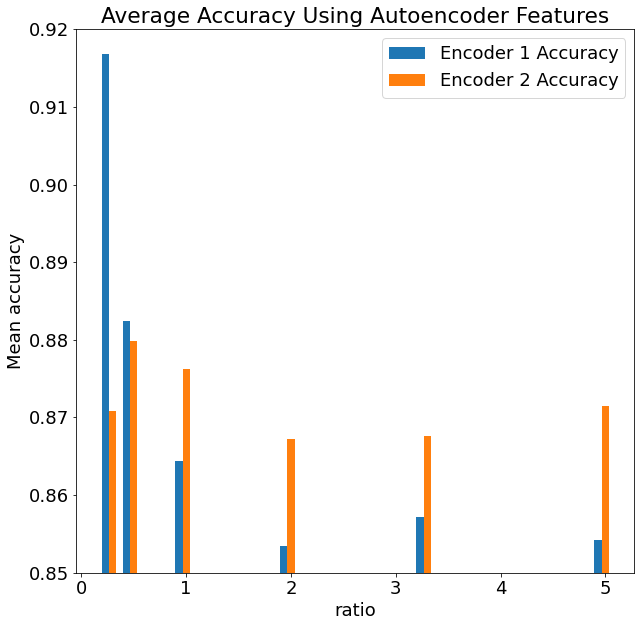

In [57]:
buf_for_plot = experiment_df_M1.copy()
buf_for_plot['accept_H0'] = buf_for_plot['pvalue']>0.05
buf_bin_val_1 = np.zeros_like(ratios)
buf_bin_val_2 = buf_bin_val_1.copy()
buf_bin_val_3 = buf_bin_val_1.copy()

for ratio_index, ratio in enumerate(ratios):
    buf_bin_val_1[ratio_index] += buf_for_plot[buf_for_plot['ratio']==ratio]['vae1_score'].mean()
    buf_bin_val_2[ratio_index] += buf_for_plot[buf_for_plot['ratio']==ratio]['vae2_score'].mean()
    buf_bin_val_3[ratio_index] += buf_for_plot[buf_for_plot['ratio']==ratio]['unenc_score'].mean()


plt.figure(figsize=(10,10))
plt.bar(ratios_for_plot - 0.07, buf_bin_val_1, width=0.07, label='Encoder 1 Accuracy')
plt.bar(ratios_for_plot, buf_bin_val_2, width=0.07, label='Encoder 2 Accuracy')
# plt.bar(ratios_for_plot + 0.05, buf_bin_val_3, width=0.05, label='unencoded accuracy')
plt.ylim(0.85, 0.92)
plt.xlabel('ratio')
plt.ylabel('Mean accuracy')
plt.legend()
plt.title('Average Accuracy Using Autoencoder Features')

In [31]:
buf_for_plot_1

'ratio'

In [59]:
vae_1_params = [(200, 5), (200, 20), (400, 50), (800, 20), (800, 50)]

In [60]:
experiment_df_M1_table = pd.DataFrame(columns=['ratio', 'pvalue', 'tstat', 'sigma', 
                                      'MMDXY', 'MMDXZ', 'vae1_score', 'vae2_score', 'unenc_score'])

experiment_df_M2_table = experiment_df_M1_table.copy()

In [66]:
for exp_index in range(13):
    print('EXPERIMENT No', exp_index, '\n\n\n\n')
    for vae_1_param in vae_1_params:
        # ratios=np.array([0.5,1,2])
        rand_indexes = np.random.permutation(np.arange(x_train.shape[0], dtype=np.int))
        data = x_train.copy()[rand_indexes,:]
        t_size2 = 2000
        t_size1 = int(t_size2 / ratio)

        set1, set2 = train_test_split(list(range(data.shape[0])), train_size=t_size1 + t_size2)
        data1 = data[set1[0:t_size1], :]
        data2 = data[set1[t_size1:t_size2 + t_size1], :]
        set2 = set2[0:samp_size]
        data_holdout = data[set2, :]

        [N1, dimX] = data1.shape
        [N2, dimX] = data2.shape
        
        HU_decoder_1 = vae_1_param[0]
        HU_encoder_1 = vae_1_param[0]
        dim_Z_vae1 = vae_1_param[1]
        encoder1 = VariationalAutoencoder.VA(HU_decoder_1, HU_encoder_1, dimX, 
                                             dim_Z_vae1, batch_size, L, learning_rate, 
                                             continous=False)
        encoder2 = VariationalAutoencoder.VA(HU_decoder2, HU_encoder2, dimX, 
                                             dimZ2, batch_size, L, learning_rate,
                                             continous=False)

        print("Creating Theano functions")
        encoder1.createGradientFunctions()
        encoder2.createGradientFunctions()
        print("Initializing weights and biases")
        encoder1.initParams()
        encoder2.initParams()

        begin = time.time()
        maxiter = 2000
        testlowerbound1 = testlowerbound2 = -np.Inf
        for j in tnrange(maxiter):
            encoder1.iterate(data1)
            if j % 1 == 0:
                oldlower = testlowerbound1
                train_lower1 = encoder1.getLowerBound(data1)
                testlowerbound1 = encoder1.getLowerBound(data_holdout)
    #             if (verbose):
    #                 print(("Encoder 1 Iteration %d| lower bound train = %.2f |lower bound test 1= %.2f"
    #                        % (j, train_lower1 / float(N1), testlowerbound1 / samp_size)))
                if (oldlower >= testlowerbound1):
                    break
                best_encoder1 = copy.deepcopy(encoder1)
        oldlower_1 = oldlower
        encoder1 = best_encoder1

        for j in tnrange(maxiter):
            encoder2.iterate(data2)

            if j % 1 == 0:
                oldlower = testlowerbound2
                train_lower2 = encoder2.getLowerBound(data2)
                testlowerbound2 = encoder2.getLowerBound(data_holdout)
    #             if (verbose):
    #                 print(("Encoder 2 Iteration %d| lower bound train = %.2f |lower bound test 1= %.2f"
    #                        % (j, train_lower2 / float(N2), testlowerbound2 / samp_size)))
                if (oldlower > testlowerbound2):
                    break
                best_encoder2 = copy.deepcopy(encoder2)
        oldlower_2 = oldlower
        encoder2 = best_encoder2
        end = time.time()

        samples1 = encoder1.sample(N=samp_size)
        samples2 = encoder2.sample(N=samp_size)

        pvalue_1, tstat_1, sigma_1, MMDXY_1, MMDXZ_1 = MMD_3_Sample_Test(data_holdout, 
                                                               samples1, 
                                                               samples2, 
                                                               computeMMDs=True)
        pvalue_2, tstat_2, sigma_2, MMDXY_2, MMDXZ_2 = MMD_3_Sample_Test(data_holdout, 
                                                           samples2, 
                                                           samples1, 
                                                           computeMMDs=True)
        print(("MMD(enc1 samples,real): %.4f MMD(enc2 samples,real): %.4f , pvalue: %.2f" % (MMDXY_1, MMDXZ_1, pvalue_1)))
        # Regressions
        ##Train regression

        data1_enc = encoder1.encode(x_valid)
        data2_enc = encoder2.encode(x_valid)
        test1_enc = encoder1.encode(x_test)
        test2_enc = encoder2.encode(x_test)

        LogReg_VAE = linear_model.LogisticRegression()
        LogReg_VAE.fit(data1_enc, t_valid)
        vae1_score = LogReg_VAE.score(test1_enc, t_test)
        LogReg_VAE = linear_model.LogisticRegression()
        LogReg_VAE.fit(data2_enc, t_valid)
        vae2_score = LogReg_VAE.score(test2_enc, t_test)
        
        LogReg_VAE = linear_model.LogisticRegression()
        LogReg_VAE.fit(x_train, t_train)
        unenc_score = LogReg_VAE.score(x_valid, t_valid)

        
        print(("Accuracy 1:%.2f Accuracy2:%.2f" % (vae1_score, vae2_score)))
        buf_dict = {'ratio': ratio, 'pvalue': pvalue_1, 'tstat': tstat_1, 
                 'sigma': sigma_1, 'MMDXY': MMDXY_1, 'MMDXZ': MMDXZ_1, 
                 'vae1_score': vae1_score, 'vae2_score': vae2_score, 
                    'unenc_score': unenc_score, 'oldlower': oldlower_1}
        experiment_df_M1_table = experiment_df_M1_table.append(buf_dict, ignore_index=True)

        buf_dict = {'ratio': ratio, 'pvalue': pvalue_2, 'tstat': tstat_2, 
             'sigma': sigma_2, 'MMDXY': MMDXY_2, 'MMDXZ': MMDXZ_2, 
             'vae1_score': vae1_score, 'vae2_score': vae2_score,
                   'unenc_score': unenc_score, 'oldlower': oldlower_2}
        experiment_df_M2_table = experiment_df_M2_table.append(buf_dict, ignore_index=True)

EXPERIMENT No 0 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.9674093176844426e-05
Diff_Var: () 5.967409317684465e-05
MMD(enc1 samples,real): 0.2405 MMD(enc2 samples,real): 0.1397 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.81 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.291019787934005e-05
Diff_Var: () 4.2910197879340274e-05
MMD(enc1 samples,real): 0.2292 MMD(enc2 samples,real): 0.2335 , pvalue: 0.74


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.81 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.175534701247157e-05
Diff_Var: () 7.175534701247223e-05
MMD(enc1 samples,real): 0.2167 MMD(enc2 samples,real): 0.1810 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.650773478754978e-05
Diff_Var: () 5.650773478755e-05
MMD(enc1 samples,real): 0.2177 MMD(enc2 samples,real): 0.1673 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.6807580346881974e-05
Diff_Var: () 5.6807580346882415e-05
MMD(enc1 samples,real): 0.2549 MMD(enc2 samples,real): 0.1090 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.90
EXPERIMENT No 1 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.24439233325876e-05
Diff_Var: () 6.244392333258716e-05
MMD(enc1 samples,real): 0.1681 MMD(enc2 samples,real): 0.1599 , pvalue: 0.15


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.80 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.1244657246685454e-05
Diff_Var: () 5.124465724668567e-05
MMD(enc1 samples,real): 0.2524 MMD(enc2 samples,real): 0.2255 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.78 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.698319585072337e-05
Diff_Var: () 6.698319585072381e-05
MMD(enc1 samples,real): 0.2610 MMD(enc2 samples,real): 0.1637 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.30389775143444e-05
Diff_Var: () 6.303897751434352e-05
MMD(enc1 samples,real): 0.2487 MMD(enc2 samples,real): 0.1362 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.90
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.126531738648862e-05
Diff_Var: () 6.126531738648839e-05
MMD(enc1 samples,real): 0.2192 MMD(enc2 samples,real): 0.1465 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
EXPERIMENT No 2 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.6144745212650685e-05
Diff_Var: () 5.614474521265091e-05
MMD(enc1 samples,real): 0.2174 MMD(enc2 samples,real): 0.1200 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.81 Accuracy2:0.90
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.7102442292873174e-05
Diff_Var: () 5.710244229287384e-05
MMD(enc1 samples,real): 0.2579 MMD(enc2 samples,real): 0.1798 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.81 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.215605440374759e-05
Diff_Var: () 5.215605440374782e-05
MMD(enc1 samples,real): 0.2314 MMD(enc2 samples,real): 0.2225 , pvalue: 0.11


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.353349462244618e-05
Diff_Var: () 5.3533494622445965e-05
MMD(enc1 samples,real): 0.2564 MMD(enc2 samples,real): 0.1881 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.938920158698335e-05
Diff_Var: () 4.938920158698379e-05
MMD(enc1 samples,real): 0.2341 MMD(enc2 samples,real): 0.2046 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.86
EXPERIMENT No 3 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.804448240815367e-05
Diff_Var: () 6.804448240815367e-05
MMD(enc1 samples,real): 0.1907 MMD(enc2 samples,real): 0.1710 , pvalue: 0.01


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.81 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.083203591099914e-05
Diff_Var: () 5.083203591099936e-05
MMD(enc1 samples,real): 0.2572 MMD(enc2 samples,real): 0.1404 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.81 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.151512231153043e-05
Diff_Var: () 7.151512231153065e-05
MMD(enc1 samples,real): 0.2316 MMD(enc2 samples,real): 0.1618 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.84
Creating Theano functions
Initializing weights and biases



Diff_Var: () 3.862601380595273e-05
Diff_Var: () 3.862601380595207e-05
MMD(enc1 samples,real): 0.2606 MMD(enc2 samples,real): 0.2108 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.79
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.542843252879338e-05
Diff_Var: () 5.542843252879427e-05
MMD(enc1 samples,real): 0.2617 MMD(enc2 samples,real): 0.1959 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.87
EXPERIMENT No 4 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.650570018844397e-05
Diff_Var: () 4.650570018844464e-05
MMD(enc1 samples,real): 0.2029 MMD(enc2 samples,real): 0.2207 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.76 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.654205183056462e-05
Diff_Var: () 7.654205183056439e-05
MMD(enc1 samples,real): 0.2186 MMD(enc2 samples,real): 0.1511 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.83 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.9163590122908583e-05
Diff_Var: () 5.916359012290792e-05
MMD(enc1 samples,real): 0.2256 MMD(enc2 samples,real): 0.1351 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.0155602120259437e-05
Diff_Var: () 6.015560212025988e-05
MMD(enc1 samples,real): 0.2304 MMD(enc2 samples,real): 0.1819 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.068090646441242e-05
Diff_Var: () 5.0680906464412194e-05
MMD(enc1 samples,real): 0.2487 MMD(enc2 samples,real): 0.2045 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.89 Accuracy2:0.86
EXPERIMENT No 5 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.283445293316237e-05
Diff_Var: () 6.28344529331626e-05
MMD(enc1 samples,real): 0.2006 MMD(enc2 samples,real): 0.1581 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.80 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.979820908698731e-05
Diff_Var: () 5.979820908698731e-05
MMD(enc1 samples,real): 0.2496 MMD(enc2 samples,real): 0.1727 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.79 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.738760741905062e-05
Diff_Var: () 6.73876074190504e-05
MMD(enc1 samples,real): 0.2422 MMD(enc2 samples,real): 0.1770 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.910225015367404e-05
Diff_Var: () 5.9102250153674485e-05
MMD(enc1 samples,real): 0.2121 MMD(enc2 samples,real): 0.1828 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.592520998700151e-05
Diff_Var: () 5.592520998700195e-05
MMD(enc1 samples,real): 0.2539 MMD(enc2 samples,real): 0.1961 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.86
EXPERIMENT No 6 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 3.626754858192657e-05
Diff_Var: () 3.6267548581927236e-05
MMD(enc1 samples,real): 0.1874 MMD(enc2 samples,real): 0.2476 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.75 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.7771446108324604e-05
Diff_Var: () 5.777144610832438e-05
MMD(enc1 samples,real): 0.2317 MMD(enc2 samples,real): 0.1726 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.83 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.822249306102842e-05
Diff_Var: () 6.822249306102842e-05
MMD(enc1 samples,real): 0.2400 MMD(enc2 samples,real): 0.1751 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.83 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.1688839180515385e-05
Diff_Var: () 5.1688839180514714e-05
MMD(enc1 samples,real): 0.2313 MMD(enc2 samples,real): 0.2053 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.700438774584112e-05
Diff_Var: () 5.700438774584068e-05
MMD(enc1 samples,real): 0.2412 MMD(enc2 samples,real): 0.1912 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.88
EXPERIMENT No 7 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.529262324132171e-05
Diff_Var: () 4.529262324132127e-05
MMD(enc1 samples,real): 0.2002 MMD(enc2 samples,real): 0.2219 , pvalue: 1.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.80 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.2175960589976324e-05
Diff_Var: () 5.2175960589976324e-05
MMD(enc1 samples,real): 0.2551 MMD(enc2 samples,real): 0.1866 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.80 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 8.060518915040867e-05
Diff_Var: () 8.060518915040888e-05
MMD(enc1 samples,real): 0.2230 MMD(enc2 samples,real): 0.1735 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.83 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 3.4400661737110775e-05
Diff_Var: () 3.440066173711055e-05
MMD(enc1 samples,real): 0.2686 MMD(enc2 samples,real): 0.2308 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.146450684468236e-05
Diff_Var: () 7.146450684468214e-05
MMD(enc1 samples,real): 0.2398 MMD(enc2 samples,real): 0.1863 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.86
EXPERIMENT No 8 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.919580175705197e-05
Diff_Var: () 4.9195801757052634e-05
MMD(enc1 samples,real): 0.2147 MMD(enc2 samples,real): 0.1884 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.80 Accuracy2:0.85
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.255290004540223e-05
Diff_Var: () 6.2552900045402e-05
MMD(enc1 samples,real): 0.2425 MMD(enc2 samples,real): 0.1643 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.73 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.408976241383248e-05
Diff_Var: () 6.408976241383226e-05
MMD(enc1 samples,real): 0.2472 MMD(enc2 samples,real): 0.1619 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.903393214484701e-05
Diff_Var: () 4.9033932144846346e-05
MMD(enc1 samples,real): 0.2228 MMD(enc2 samples,real): 0.1681 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.4751589190890424e-05
Diff_Var: () 5.4751589190891535e-05
MMD(enc1 samples,real): 0.2683 MMD(enc2 samples,real): 0.1768 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.86
EXPERIMENT No 9 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.8960540178399466e-05
Diff_Var: () 5.896054017839969e-05
MMD(enc1 samples,real): 0.2058 MMD(enc2 samples,real): 0.1890 , pvalue: 0.01


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.78 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.195374663839438e-05
Diff_Var: () 6.195374663839393e-05
MMD(enc1 samples,real): 0.2464 MMD(enc2 samples,real): 0.1466 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.522848600231231e-05
Diff_Var: () 6.522848600231208e-05
MMD(enc1 samples,real): 0.2542 MMD(enc2 samples,real): 0.1898 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.381005306383385e-05
Diff_Var: () 5.381005306383385e-05
MMD(enc1 samples,real): 0.2225 MMD(enc2 samples,real): 0.1179 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.3640319842333264e-05
Diff_Var: () 5.3640319842333264e-05
MMD(enc1 samples,real): 0.2588 MMD(enc2 samples,real): 0.1707 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.87
EXPERIMENT No 10 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.281605151887942e-05
Diff_Var: () 7.281605151887897e-05
MMD(enc1 samples,real): 0.2071 MMD(enc2 samples,real): 0.1636 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.76 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.557276792945417e-05
Diff_Var: () 5.557276792945373e-05
MMD(enc1 samples,real): 0.2582 MMD(enc2 samples,real): 0.1615 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.72 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.387217640073248e-05
Diff_Var: () 4.387217640073248e-05
MMD(enc1 samples,real): 0.2327 MMD(enc2 samples,real): 0.2316 , pvalue: 0.43


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.84 Accuracy2:0.84
Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.159220640799971e-05
Diff_Var: () 4.159220640799927e-05
MMD(enc1 samples,real): 0.2580 MMD(enc2 samples,real): 0.1957 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.87
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.5539566287424496e-05
Diff_Var: () 5.553956628742361e-05
MMD(enc1 samples,real): 0.2709 MMD(enc2 samples,real): 0.1818 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.86
EXPERIMENT No 11 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.279292432208001e-05
Diff_Var: () 6.279292432208001e-05
MMD(enc1 samples,real): 0.1950 MMD(enc2 samples,real): 0.1968 , pvalue: 0.59


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.76 Accuracy2:0.86
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.125971741520022e-05
Diff_Var: () 7.125971741520022e-05
MMD(enc1 samples,real): 0.2436 MMD(enc2 samples,real): 0.1532 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.78 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.579638659533282e-05
Diff_Var: () 6.579638659533215e-05
MMD(enc1 samples,real): 0.2394 MMD(enc2 samples,real): 0.1558 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.80 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.227004858769822e-05
Diff_Var: () 6.227004858769867e-05
MMD(enc1 samples,real): 0.2246 MMD(enc2 samples,real): 0.1647 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.86 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 4.876060662791508e-05
Diff_Var: () 4.876060662791419e-05
MMD(enc1 samples,real): 0.2585 MMD(enc2 samples,real): 0.1508 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.87
EXPERIMENT No 12 




Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.070915541256097e-05
Diff_Var: () 7.070915541256208e-05
MMD(enc1 samples,real): 0.1864 MMD(enc2 samples,real): 0.1646 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.77 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 7.539830250472418e-05
Diff_Var: () 7.539830250472418e-05
MMD(enc1 samples,real): 0.2515 MMD(enc2 samples,real): 0.1412 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.83 Accuracy2:0.89
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.635297462327118e-05
Diff_Var: () 6.635297462327095e-05
MMD(enc1 samples,real): 0.2441 MMD(enc2 samples,real): 0.1582 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.85 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 6.511429587779004e-05
Diff_Var: () 6.511429587778981e-05
MMD(enc1 samples,real): 0.2135 MMD(enc2 samples,real): 0.1714 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.88 Accuracy2:0.88
Creating Theano functions
Initializing weights and biases



Diff_Var: () 5.315417621830048e-05
Diff_Var: () 5.315417621830004e-05
MMD(enc1 samples,real): 0.2474 MMD(enc2 samples,real): 0.2031 , pvalue: 0.00


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Accuracy 1:0.87 Accuracy2:0.87


/home/di/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
experiment_df_M1_table

,ratio,pvalue,tstat,sigma,MMDXY,MMDXZ,vae1_score,vae2_score,unenc_score,oldlower
0,5.0,1.946838e-19,8.939944,12.344760,0.219056,0.145321,0.7668,0.8919,0.9203,NaN
1,5.0,9.531695e-02,1.308706,13.171721,0.228452,0.218007,0.8360,0.8649,0.9203,NaN
2,5.0,1.572183e-03,2.953260,13.341546,0.242461,0.221516,0.8585,0.8519,0.9203,NaN
3,5.0,8.302119e-08,5.233820,13.207892,0.242134,0.202546,0.8609,0.8553,0.9203,NaN
4,5.0,9.943262e-01,-2.531809,13.369189,0.228193,0.244243,0.8930,0.8524,0.9203,NaN
...,...,...,...,...,...,...,...,...,...,...
120,5.0,4.739150e-03,2.594303,12.385812,0.186373,0.164558,0.7691,0.8907,0.9203,-220.034642
121,5.0,2.862087e-37,12.702539,12.560554,0.251486,0.141187,0.8348,0.8945,0.9203,-227.207739
122,5.0,2.506804e-26,10.551231,12.682254,0.244108,0.158161,0.8465,0.8822,0.9203,-230.016486
123,5.0,9.282937e-08,5.213152,12.705279,0.213479,0.171413,0.8752,0.8819,0.9203,-225.204733


In [69]:
experiment_df_M2_table

,ratio,pvalue,tstat,sigma,MMDXY,MMDXZ,vae1_score,vae2_score,unenc_score,oldlower
0,5.0,1.000000,-8.939944,12.344760,0.145321,0.219056,0.7668,0.8919,0.9203,NaN
1,5.0,0.904683,-1.308706,13.171721,0.218007,0.228452,0.8360,0.8649,0.9203,NaN
2,5.0,0.998428,-2.953260,13.341546,0.221516,0.242461,0.8585,0.8519,0.9203,NaN
3,5.0,1.000000,-5.233820,13.207892,0.202546,0.242134,0.8609,0.8553,0.9203,NaN
4,5.0,0.005674,2.531809,13.369189,0.244243,0.228193,0.8930,0.8524,0.9203,NaN
...,...,...,...,...,...,...,...,...,...,...
120,5.0,0.995261,-2.594303,12.385812,0.164558,0.186373,0.7691,0.8907,0.9203,-177.745188
121,5.0,1.000000,-12.702539,12.560554,0.141187,0.251486,0.8348,0.8945,0.9203,-173.643815
122,5.0,1.000000,-10.551231,12.682254,0.158161,0.244108,0.8465,0.8822,0.9203,-190.372183
123,5.0,1.000000,-5.213152,12.705279,0.171413,0.213479,0.8752,0.8819,0.9203,-190.382855


In [68]:
experiment_df_M1_table.to_csv('experiment_df_M1_table_v2.csv')
experiment_df_M2_table.to_csv('experiment_df_M2_table_v2.csv')